# Drowsiness Detection Performance Analyzer
This notebook analyzes the results of our synthesized PERCLOS calculator in hopes of grading its accuracy at accessing drowsiness.
We collected data from the PERCLOS calculator while user completed reaction time tests. 

## Prerequisites
If you encounter errors, please ensure you have all required libraries:
```bash
pip install pandas matplotlib opencv-python 
```

In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from io import BytesIO
import os

# Set Plot Style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Configuration & Data Loading

In [203]:
# --- USER CONFIGURATION ---
DATA_DIR = './data/'                  # Path to data directory
ALERT_ID = '20251211_115834'          # ID for Alert Session
DROWSY_ID = '20251208_001154'         # ID for Drowsy Session

In [204]:
class Dataset:
    def __init__(self, dataset_id):
        """
        Initialize the dataset with paths.
        """
        self.id = dataset_id
        self.perclos_path = os.path.join(DATA_DIR, f'data_{dataset_id}.csv')
        self.reaction_path = os.path.join(DATA_DIR, f'reaction_time_data_{dataset_id}.csv')
        self.video_path = os.path.join(DATA_DIR, f'video_{dataset_id}.mp4')
        
        # Placeholders for data
        self.perclos_df = None
        self.reaction_df = None
        self.merged_df = None

    def load_data(self):
        """
        Loads CSVs, cleans timestamps, and performs the merge automatically.
        """
        # 1. Check Files
        if not os.path.exists(self.perclos_path):
            raise FileNotFoundError(f"PERCLOS file missing: {self.perclos_path}")
        if not os.path.exists(self.reaction_path):
            print(f"Warning: Reaction time file missing for {self.id} ({self.reaction_path})")
            # We allow loading just PERCLOS if reaction data is missing
        
        # 2. Load Main Sensor Data (PERCLOS)
        print(f"Loading data for {self.id}...")
        self.perclos_df = pd.read_csv(self.perclos_path)
        try:
            # Standardize Main Timestamp
            self.perclos_df['Timestamp'] = pd.to_datetime(self.perclos_df['Timestamp'])
            # Sort for merging
            self.perclos_df = self.perclos_df.sort_values('Timestamp')
        except Exception as e:
            print(f"Error parsing main timestamps: {e}")

        # 3. Load & Process Reaction Data (if available)
        if os.path.exists(self.reaction_path):
            self.reaction_df = pd.read_csv(self.reaction_path)
            
            # Standardize Reaction Timestamp (Handle the 'Z' / UTC issue here)
            self.reaction_df['Timestamp'] = (
                pd.to_datetime(self.reaction_df['Timestamp'])
                .dt.tz_convert('US/Eastern')
                .dt.tz_localize(None)
            )
            
            self.reaction_df = self.reaction_df.sort_values('Timestamp')
            
            # Identify Lapses (>1000ms)
            self.reaction_df['Status'] = np.where(
                self.reaction_df['Reaction Time (ms)'] > 1000, 'Failure', 'Success'
            )

            # 4. Perform Merge (Internal method)
            self._merge_data()
            
    def _merge_data(self):
        """
        Internal helper to merge reaction times with nearest PERCLOS score
        """
        if self.perclos_df is not None and self.reaction_df is not None:
            # Merge dataframes using pd.merge_asof with nearest direction
            # reaction_df is the left dataframe (discrete events)
            # perclos_df is the right dataframe (continuous signal)
            self.merged_df = pd.merge_asof(
                self.reaction_df,
                self.perclos_df[['Timestamp', 'PERCLOS_Score', 'State']],
                on='Timestamp',
                direction='nearest',
                tolerance=pd.Timedelta('2s'), # Match within 2 seconds
                suffixes=('_rt', '_eye')
            )
            print(f" -> Merged {len(self.merged_df)} reaction tests for {self.id}.")

# --- INSTANTIATE AND LOAD ---
try:
    # 1. Create Objects
    alert = Dataset(ALERT_ID)
    drowsy = Dataset(DROWSY_ID)

    # 2. Load Data
    alert.load_data()
    drowsy.load_data()

    # 3. Tag Data for Comparison (Applied externally)
    if drowsy.perclos_df is not None: drowsy.perclos_df['Condition'] = 'Drowsy'
    if alert.perclos_df is not None: alert.perclos_df['Condition'] = 'Alert'
    
    if drowsy.merged_df is not None: drowsy.merged_df['Condition'] = 'Drowsy'
    if alert.merged_df is not None: alert.merged_df['Condition'] = 'Alert'
    
except Exception as e:
    print(f"Initialization Error: {e}")

Loading data for 20251211_115834...
 -> Merged 100 reaction tests for 20251211_115834.
Loading data for 20251208_001154...


C:\Users\jjluk\AppData\Local\Temp\ipykernel_46592\4042104658.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.perclos_df['Timestamp'] = pd.to_datetime(self.perclos_df['Timestamp'])
C:\Users\jjluk\AppData\Local\Temp\ipykernel_46592\4042104658.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.perclos_df['Timestamp'] = pd.to_datetime(self.perclos_df['Timestamp'])


 -> Merged 100 reaction tests for 20251208_001154.


# Alert Dataset

In [205]:
alert.perclos_df.describe()

,Timestamp,Selected_EAR,Smooth_EAR,Threshold,Pitch_Ratio,Pitch_Threshold,Yaw_Ratio,PERCLOS_Score
count,5517,5517.000000,5517.000000,5.517000e+03,5517.000000,5.517000e+03,5517.000000,5517.000000
mean,2025-12-11 12:02:58.597101824,28.387812,28.386420,2.245000e+01,6.132927,4.990000e+00,0.987925,1.210005
min,2025-12-11 11:59:29.810000,16.260000,16.880000,2.245000e+01,5.670000,4.990000e+00,0.950000,0.000000
25%,2025-12-11 12:01:08.217999872,27.860000,27.680000,2.245000e+01,6.000000,4.990000e+00,0.980000,0.000000
50%,2025-12-11 12:02:58.185999872,28.940000,28.660000,2.245000e+01,6.170000,4.990000e+00,1.000000,0.300000
75%,2025-12-11 12:04:48.428999936,29.950000,29.840000,2.245000e+01,6.250000,4.990000e+00,1.000000,1.700000
max,2025-12-11 12:06:36.513000,32.710000,32.460000,2.245000e+01,6.520000,4.990000e+00,1.000000,9.300000
std,NaN,2.612366,2.060712,7.106071e-15,0.166026,8.882589e-16,0.013818,1.967859


In [206]:
alert.reaction_df.describe()

,Attempt ID,Reaction Time (ms),Timestamp
count,100.000000,100.000000,100
mean,50.500000,305.090000,2025-12-11 12:03:07.210549760
min,1.000000,246.000000,2025-12-11 11:59:45.368000
25%,25.750000,281.750000,2025-12-11 12:01:25.411250176
50%,50.500000,293.500000,2025-12-11 12:03:04.512499968
75%,75.250000,317.000000,2025-12-11 12:04:54.528499968
max,100.000000,457.000000,2025-12-11 12:06:28.005000
std,29.011492,37.205977,NaN


In [207]:
alert.merged_df.describe()

,Attempt ID,Reaction Time (ms),Timestamp,PERCLOS_Score
count,100.000000,100.000000,100,100.000000
mean,50.500000,305.090000,2025-12-11 12:03:07.210549760,1.249000
min,1.000000,246.000000,2025-12-11 11:59:45.368000,0.000000
25%,25.750000,281.750000,2025-12-11 12:01:25.411250176,0.000000
50%,50.500000,293.500000,2025-12-11 12:03:04.512499968,0.300000
75%,75.250000,317.000000,2025-12-11 12:04:54.528499968,1.700000
max,100.000000,457.000000,2025-12-11 12:06:28.005000,9.000000
std,29.011492,37.205977,NaN,2.034624


# Drowsy Dataset

In [208]:
drowsy.perclos_df.describe()

,Timestamp,Selected_EAR,Smooth_EAR,Threshold,Pitch_Ratio,Pitch_Threshold,Yaw_Ratio,PERCLOS_Score
count,7052,7052.000000,7052.000000,7.052000e+03,7052.000000,7.052000e+03,7052.000000,7052.000000
mean,2025-12-11 00:16:14.757730304,22.941492,22.941626,2.079000e+01,6.290393,5.330000e+00,0.977019,17.288911
min,2025-12-11 00:12:25.323000,8.670000,12.270000,2.079000e+01,5.370000,5.330000e+00,0.680000,0.000000
25%,2025-12-11 00:14:16.220000,21.795000,21.850000,2.079000e+01,6.190000,5.330000e+00,0.970000,11.300000
50%,2025-12-11 00:16:14.785999872,23.370000,23.520000,2.079000e+01,6.310000,5.330000e+00,0.980000,17.700000
75%,2025-12-11 00:18:13.022749952,25.230000,24.940000,2.079000e+01,6.370000,5.330000e+00,1.000000,22.700000
max,2025-12-11 00:20:09.352000,31.810000,31.080000,2.079000e+01,6.900000,5.330000e+00,1.000000,43.000000
std,NaN,3.327250,2.945859,3.552966e-15,0.147225,8.882414e-16,0.029723,8.831473


In [209]:
drowsy.reaction_df.describe()

,Attempt ID,Reaction Time (ms),Timestamp
count,100.000000,100.000000,100
mean,50.500000,355.300000,2025-12-08 00:16:20.745390336
min,1.000000,253.000000,2025-12-08 00:12:40.388000
25%,25.750000,305.250000,2025-12-08 00:14:31.000999936
50%,50.500000,327.000000,2025-12-08 00:16:22.772999936
75%,75.250000,366.750000,2025-12-08 00:18:11.635249920
max,100.000000,1329.000000,2025-12-08 00:19:57.724000
std,29.011492,117.591357,NaN


In [210]:
drowsy.merged_df.describe()

,Attempt ID,Reaction Time (ms),Timestamp,PERCLOS_Score
count,100.000000,100.000000,100,0.0
mean,50.500000,355.300000,2025-12-08 00:16:20.745390336,NaN
min,1.000000,253.000000,2025-12-08 00:12:40.388000,NaN
25%,25.750000,305.250000,2025-12-08 00:14:31.000999936,NaN
50%,50.500000,327.000000,2025-12-08 00:16:22.772999936,NaN
75%,75.250000,366.750000,2025-12-08 00:18:11.635249920,NaN
max,100.000000,1329.000000,2025-12-08 00:19:57.724000,NaN
std,29.011492,117.591357,NaN,NaN


## 2. Global State Distribution
How often was the driver in each state?

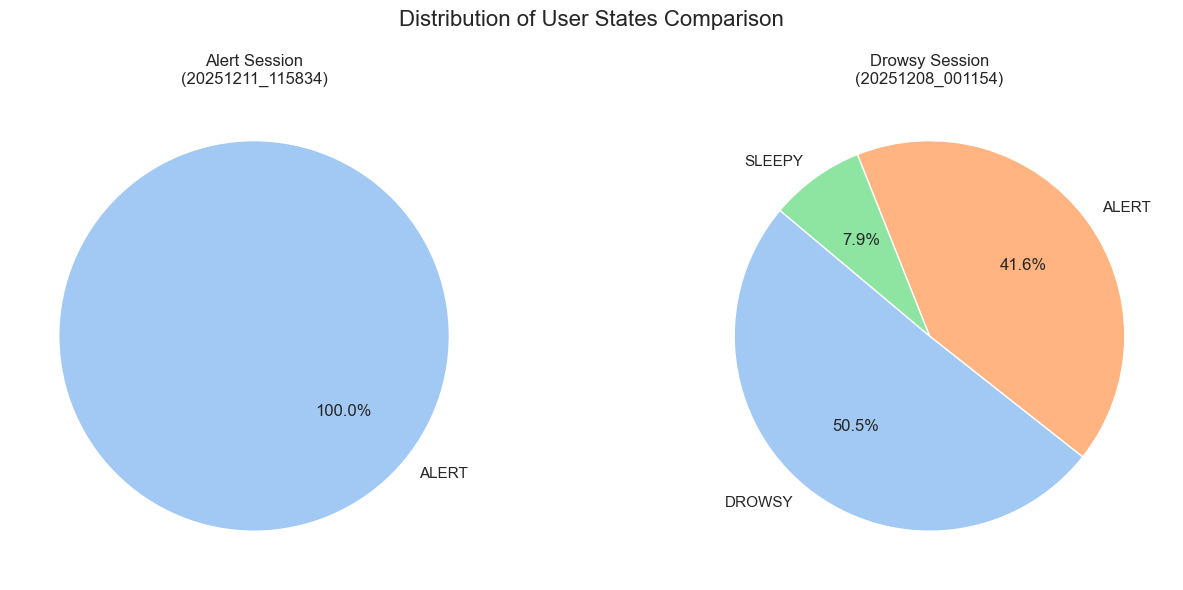

In [211]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

if alert.perclos_df is not None:
    counts_a = alert.perclos_df['State'].value_counts()
    axes[0].pie(counts_a, labels=counts_a.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'), startangle=140)
    axes[0].set_title(f'Alert Session\n({alert.id})')
else:
    axes[0].text(0.5, 0.5, 'Alert Data Not Loaded', ha='center')
    
# Check if data loaded successfully before plotting
if drowsy.perclos_df is not None:
    counts_d = drowsy.perclos_df['State'].value_counts()
    axes[1].pie(counts_d, labels=counts_d.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'), startangle=140)
    axes[1].set_title(f'Drowsy Session\n({drowsy.id})')
else:
    axes[1].text(0.5, 0.5, 'Drowsy Data Not Loaded', ha='center')

plt.suptitle("Distribution of User States Comparison", fontsize=16)
plt.tight_layout()
plt.show()

## 3. Temporal Analysis: EAR vs Threshold
This is the most critical graph. It shows the raw eye openness (Selected_EAR), the smoothed version (used to prevent flickering), and the Trigger Threshold.

* **Green Line**: Smoothed EAR
* **Red Dashed Line**: The Threshold (if EAR drops below this, eyes are closed)


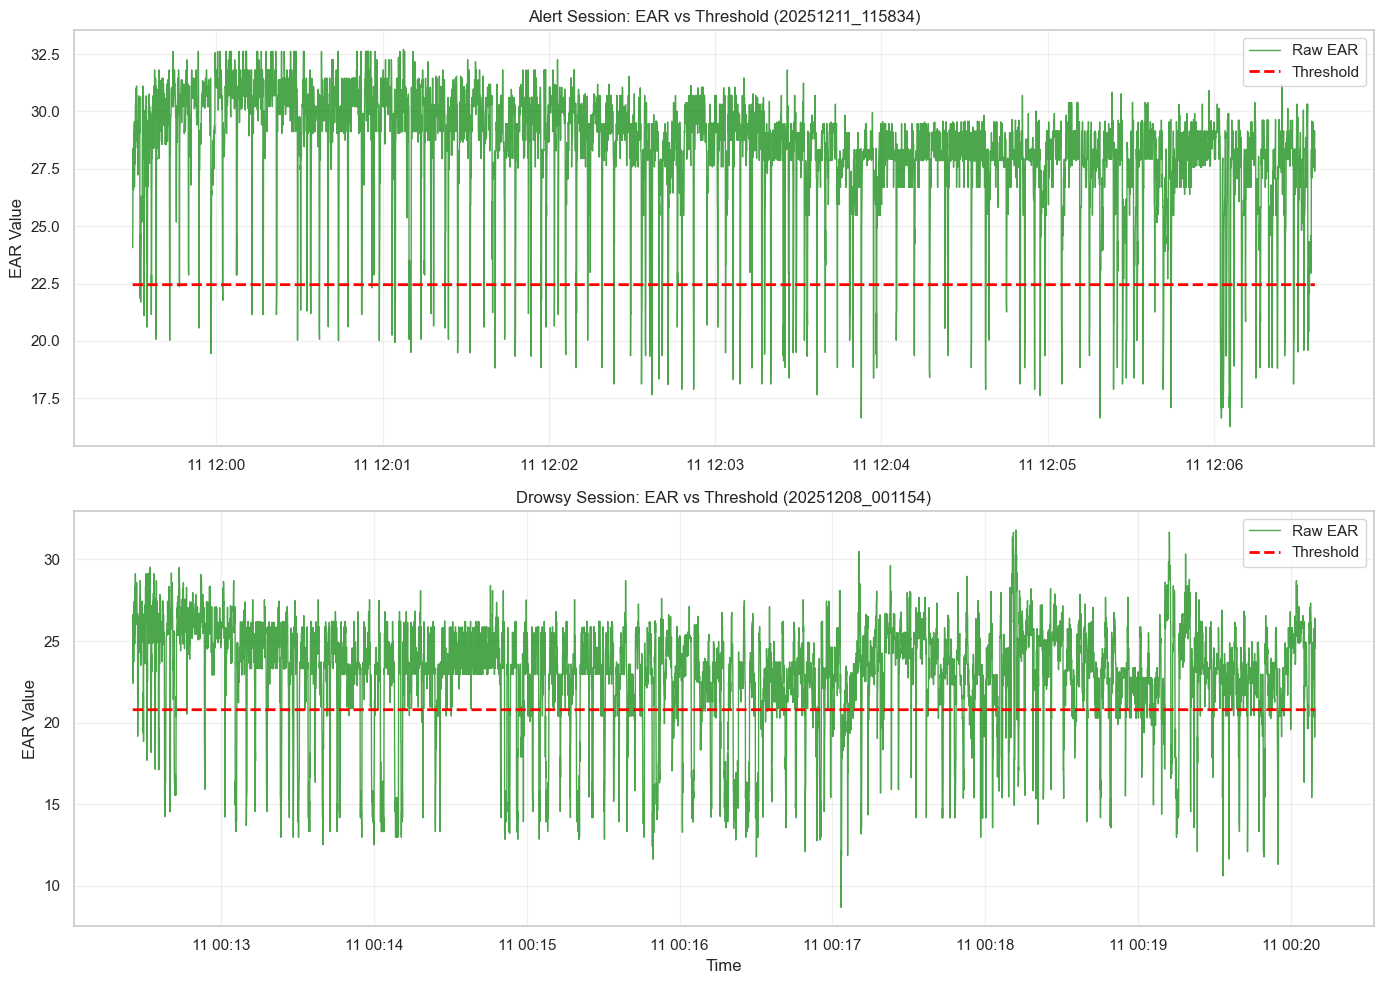

In [212]:
# Create subplots: 2 rows, 1 column to stack the timelines
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Alert Session Plot (Top)
if alert.perclos_df is not None:
    df = alert.perclos_df
    # Plot Raw EAR
    axes[0].plot(df['Timestamp'], df['Selected_EAR'], label='Raw EAR', color='green', linewidth=1, alpha=0.7)
    # Plot Threshold
    axes[0].plot(df['Timestamp'], df['Threshold'], label='Threshold', color='red', linestyle='--', linewidth=2)
    
    axes[0].set_title(f'Alert Session: EAR vs Threshold ({alert.id})')
    axes[0].set_ylabel('EAR Value')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Alert Data Not Loaded', ha='center')

# Drowsy Session Plot (Bottom)
if drowsy.perclos_df is not None:
    df = drowsy.perclos_df
    # Plot Raw EAR (Green, slightly transparent to be 'faint')
    axes[1].plot(df['Timestamp'], df['Selected_EAR'], label='Raw EAR', color='green', linewidth=1, alpha=0.7)
    # Plot Threshold
    axes[1].plot(df['Timestamp'], df['Threshold'], label='Threshold', color='red', linestyle='--', linewidth=2)
    
    axes[1].set_title(f'Drowsy Session: EAR vs Threshold ({drowsy.id})')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('EAR Value')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Drowsy Data Not Loaded', ha='center')

plt.tight_layout()
plt.show()

## 4. PERCLOS Plot
**PERCLOS** (Percentage of Eyelid Closure) is the standard safety metric.

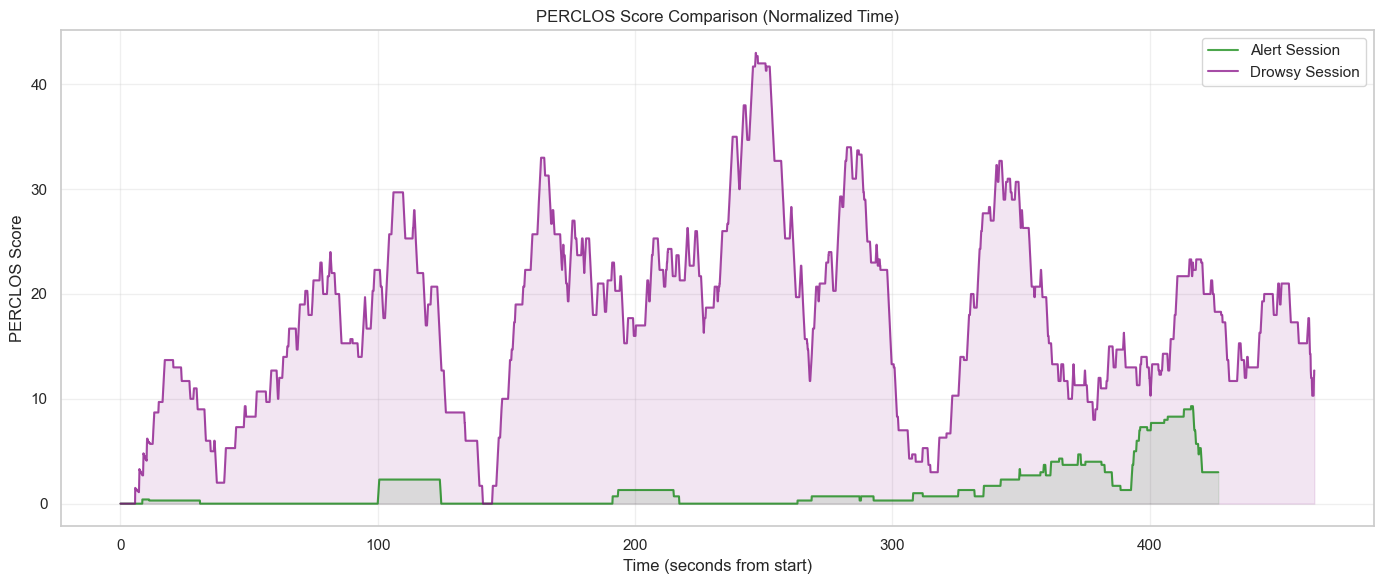

In [213]:
plt.figure(figsize=(14, 6))

# Plot Alert Session
if alert.perclos_df is not None:
    # Normalize time to start at 0 for comparison
    t_alert = (alert.perclos_df['Timestamp'] - alert.perclos_df['Timestamp'].min()).dt.total_seconds()
    plt.plot(t_alert, alert.perclos_df['PERCLOS_Score'], label='Alert Session', color='green', alpha=0.7)
    plt.fill_between(t_alert, alert.perclos_df['PERCLOS_Score'], color='green', alpha=0.1)

# Plot Drowsy Session
if drowsy.perclos_df is not None:
    # Normalize time to start at 0 for comparison
    t_drowsy = (drowsy.perclos_df['Timestamp'] - drowsy.perclos_df['Timestamp'].min()).dt.total_seconds()
    plt.plot(t_drowsy, drowsy.perclos_df['PERCLOS_Score'], label='Drowsy Session', color='purple', alpha=0.7)
    plt.fill_between(t_drowsy, drowsy.perclos_df['PERCLOS_Score'], color='purple', alpha=0.1)

plt.title("PERCLOS Score Comparison (Normalized Time)")
plt.xlabel("Time (seconds from start)")
plt.ylabel("PERCLOS Score")
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Reaction Time Distribution Analysis 

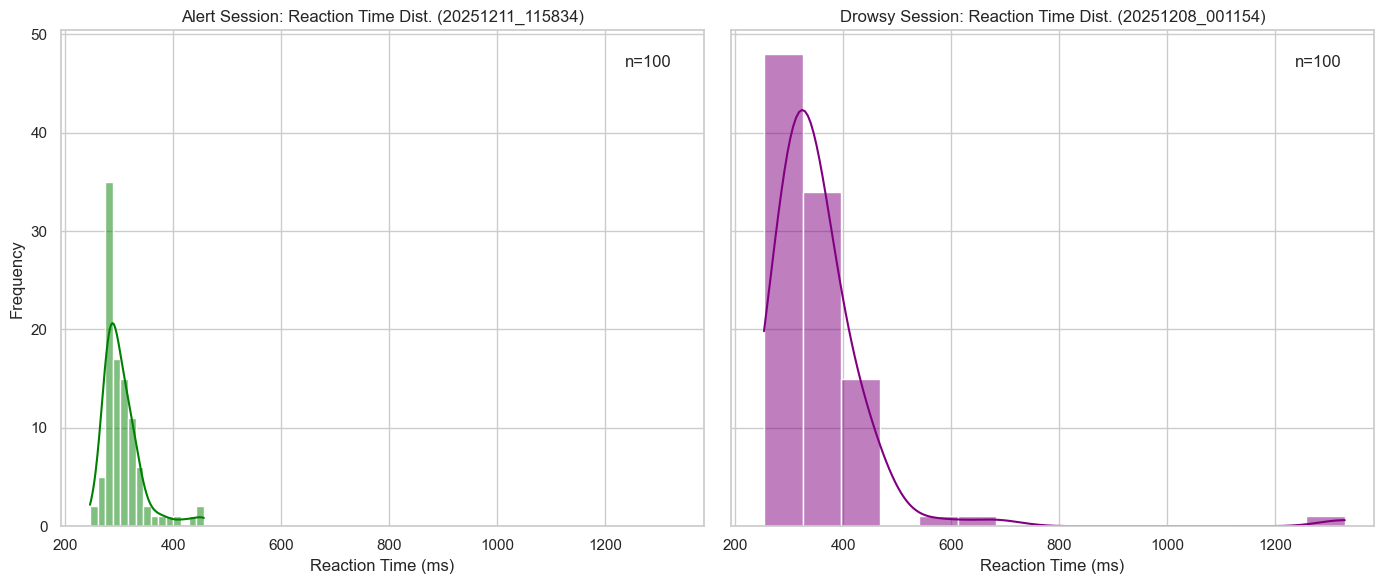

In [214]:
# Create subplots: 1 row, 2 columns, sharing axes to normalize scale
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Helper to add count annotation
def add_sample_count(ax, df):
    if df is not None:
        count = len(df)
        ax.text(0.95, 0.95, f'n={count}', transform=ax.transAxes, 
                ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Alert Session Plot (Left)
if alert.reaction_df is not None:
    # Increased bins to 15 for better resolution
    sns.histplot(alert.reaction_df['Reaction Time (ms)'], kde=True, bins=15, ax=axes[0], color='green')
    axes[0].set_title(f'Alert Session: Reaction Time Dist. ({alert.id})')
    axes[0].set_xlabel('Reaction Time (ms)')
    axes[0].set_ylabel('Frequency')
    add_sample_count(axes[0], alert.reaction_df)
else:
    axes[0].text(0.5, 0.5, 'Alert Data Not Loaded', ha='center')

# Drowsy Session Plot (Right)
if drowsy.reaction_df is not None:
    sns.histplot(drowsy.reaction_df['Reaction Time (ms)'], kde=True, bins=15, ax=axes[1], color='purple')
    axes[1].set_title(f'Drowsy Session: Reaction Time Dist. ({drowsy.id})')
    axes[1].set_xlabel('Reaction Time (ms)')
    # Y-axis is shared, so label is optional here, but good for clarity
    axes[1].set_ylabel('Frequency')
    add_sample_count(axes[1], drowsy.reaction_df)
else:
    axes[1].text(0.5, 0.5, 'Drowsy Data Not Loaded', ha='center')

plt.tight_layout()
plt.show()

### Analysis
The distribution on the left shows less variance in reaction times. 

# Box Plot Reaction Time Representation

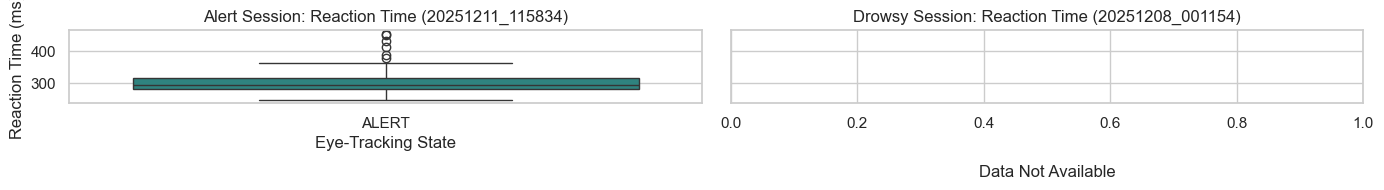

In [215]:
# Create subplots: 1 row, 2 columns, sharing Y axis for easy comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Helper function to plot safely and avoid warnings
def safe_boxplot(data, ax, title, palette):
    if data is not None and not data.empty and 'State' in data.columns:
        # Drop NaNs in State to avoid plotting issues/warnings
        clean_data = data.dropna(subset=['State'])
        if not clean_data.empty:
            sns.boxplot(
                data=clean_data, 
                x='State', 
                y='Reaction Time (ms)', 
                hue='State', 
                palette=palette, 
                legend=False, 
                ax=ax
            )
            ax.set_title(title)
            ax.set_xlabel('Eye-Tracking State')
            ax.set_ylabel('Reaction Time (ms)')
            return
    
    # Fallback if no data
    ax.text(0.5, 0.5, 'Data Not Available', ha='center')
    ax.set_title(title)

# Alert Session Plot (Left)
safe_boxplot(
    alert.merged_df, 
    axes[0], 
    f'Alert Session: Reaction Time ({alert.id})', 
    'viridis'
)

# Drowsy Session Plot (Right)
safe_boxplot(
    drowsy.merged_df, 
    axes[1], 
    f'Drowsy Session: Reaction Time ({drowsy.id})', 
    'magma'
)

plt.tight_layout()
plt.show()